# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [24]:
import tempfile
import pandas as pd
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

from io import BytesIO
from PIL import Image

from helpers import make_geoplot, make_market_plot, make_market_deep_dive_plot
from helpers import make_market_plot_multicell, make_market_deep_dive_plot_multicell

In [3]:
# Initialize R instance
r = robjects.r

In [4]:
# Install the GeoLift package
r('''
if (!require("GeoLift")) {
    install.packages("GeoLift", repos="http://cran.us.r-project.org")
    library(GeoLift)
}
''')

R[write to console]: Loading required package: GeoLift



In [5]:
# Install the dplyr package (somewhat like pandas for R), used for Multi-Cell
r('''
if (!require("dplyr")) {
    install.packages("dplyr", repos="http://cran.us.r-project.org")
    library(dplyr)
}
''')

R[write to console]: Loading required package: dplyr

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




# Multi-Cell GeoLift Planning & Analysis

>Code based on walkthrough: https://facebookincubator.github.io/GeoLift/docs/GettingStarted/MultiCellWalkthrough/

## Determining # of Cells

In [6]:
r('''
# Load data
data(GeoLift_PreTest)

# Read into GeoLifts format with GeoDataRead
GeoTestData_PreTest <- GeoDataRead(data = GeoLift_PreTest,
                                    date_id = "date",
                                    location_id = "location",
                                    Y_id = "Y",
                                    X = c(), #empty list as we have no covariates
                                    format = "yyyy-mm-dd",
                                    summary = TRUE)
''')

R[write to console]: ##################################
#####       Summary       #####
##################################

* Raw Number of Locations: 40
* Time Periods: 90
* Final Number of Locations (Complete): 40



In [17]:
r('''
print(tail(GeoTestData_PreTest))
''')

       location time    Y
3595 washington   85 2258
3596 washington   86 3037
3597 washington   87 4453
3598 washington   88 3923
3599 washington   89 2144
3600 washington   90 1996


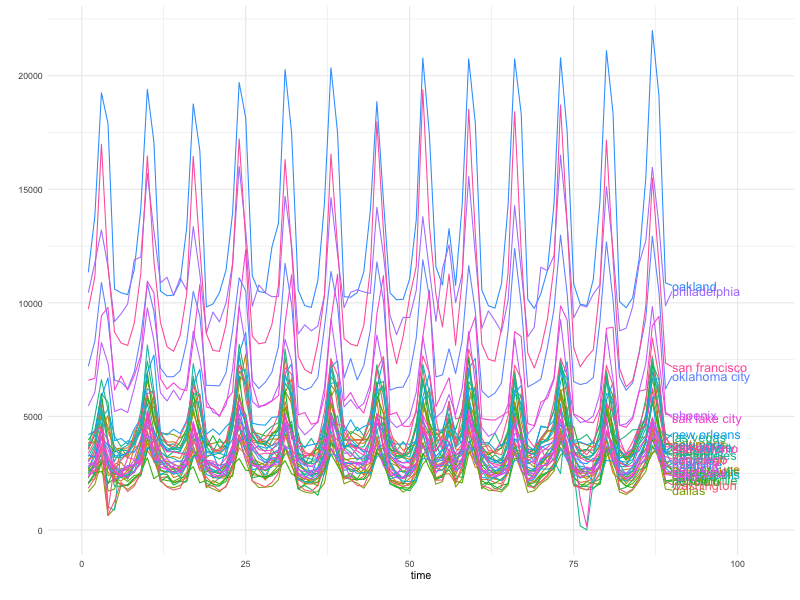

In [7]:
# Plot the KPI's historical values
p = "GeoPlot(GeoTestData_PreTest)"
make_geoplot(r, p)

## Finding test markets

In [14]:
# parameters documentation:
# https://facebookincubator.github.io/GeoLift/docs/GettingStarted/MultiCellWalkthrough/#2-finding-test-markets-with-multicellmarketselection

r('''
set.seed(8)  # to replicate the results
Markets <- MultiCellMarketSelection(data = GeoTestData_PreTest,
                                 k = 2,  # number of cells
                                 sampling_method = "systematic",
                                 top_choices = 10,
                                 N = c(2,3),
                                 effect_size = seq(0, 0.25, 0.025),
                                 treatment_periods = c(15),
                                 lookback_window = 1,
                                 cpic = c(7, 7.50),
                                 alpha = 0.1,
                                 model = "None",
                                 fixed_effects = TRUE,
                                 Correlations = TRUE,
                                 side_of_test = "one_sided",
                                 )
''')

In [15]:
r('''
print(Markets)
''')

   cell ID                            location duration EffectSize
1     1  1                 chicago, cincinnati       15      0.025
2     2  1                     baltimore, reno       15      0.025
3     1  2            cleveland, oklahoma city       15      0.050
4     2  2                       houston, reno       15      0.025
5     1  3               las vegas, saint paul       15      0.025
6     2  3              honolulu, indianapolis       15      0.025
7     1  4                nashville, san diego       15      0.025
8     2  4             houston, portland, reno       15      0.025
9     1  5               philadelphia, phoenix       15      0.025
10    2  5         denver, memphis, washington       15      0.050
11    1  6    cleveland, dallas, oklahoma city       15      0.025
12    2  6               baton rouge, portland       15      0.025
13    1  7               detroit, jacksonville       15      0.025
14    2  7                     denver, memphis       15      0

R[write to console]: You can include dates in your chart if you supply the end date of the treatment. Just specify the treatment_end_date parameter.

R[write to console]: You can include dates in your chart if you supply the end date of the treatment. Just specify the treatment_end_date parameter.



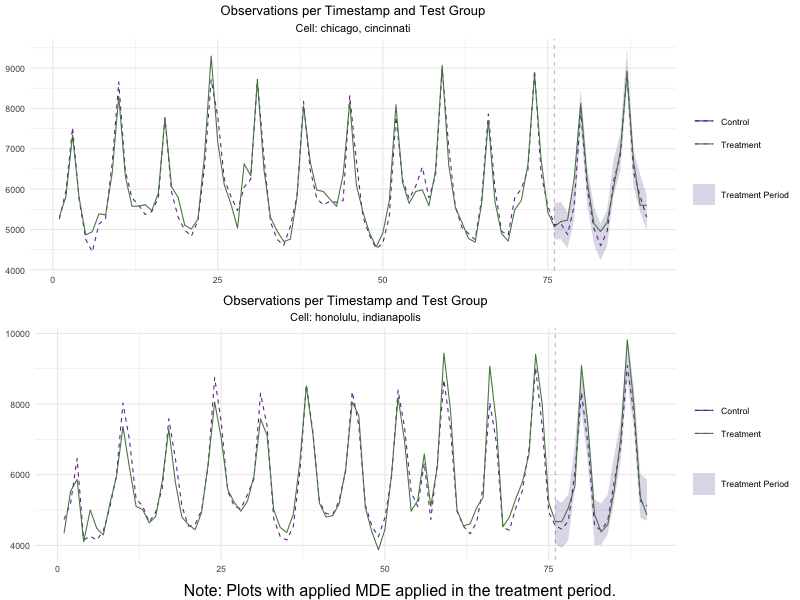

In [31]:
# # Cell and Market IDs in a list
# r('''
# test_locs <- list(cell_1 = 1, #chicago, cincinnati
#                   cell_2 = 3) #honolulu, indianapolis
# ''')

# p = '''
# plot(Markets,
#      test_markets = test_locs,
#      type = "Lift",
#      stacked = TRUE)
# '''

make_market_plot_multicell(r, market_ids=[1,   # chicago, cincinnati
                                          3],  # honolulu, indianapolis
                          )

## Detailed Power Curves

In [22]:
# r('''
# Power <- MultiCellPower(Markets,
#                         test_markets = test_locs,
#                         effect_size =  seq(-0.5, 0.5, 0.05),
#                         lookback_window = 7)
# ''')

In [23]:
# r('''
# print(head(Power))
# ''')

$PowerCurves
$PowerCurves$cell_1
               location pvalue duration EffectSize treatment_start Investment
1   chicago, cincinnati  0.000       15      -0.50              76 -310971.50
2   chicago, cincinnati  0.000       15      -0.45              76 -279874.35
3   chicago, cincinnati  0.000       15      -0.40              76 -248777.20
4   chicago, cincinnati  0.000       15      -0.35              76 -217680.05
5   chicago, cincinnati  0.000       15      -0.30              76 -186582.90
6   chicago, cincinnati  0.000       15      -0.25              76 -155485.75
7   chicago, cincinnati  0.000       15      -0.20              76 -124388.60
8   chicago, cincinnati  0.000       15      -0.15              76  -93291.45
9   chicago, cincinnati  0.000       15      -0.10              76  -62194.30
10  chicago, cincinnati  0.000       15      -0.05              76  -31097.15
11  chicago, cincinnati  0.135       15       0.00              76       0.00
12  chicago, cincinnati  0.002 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



  3989
391          boston   31  6056
392          boston   32  6655
393          boston   33  3049
394          boston   34  3237
395          boston   35  3337
396          boston   36  3403
397          boston   37  4063
398          boston   38  5863
399          boston   39  6421
400          boston   40  3529
401          boston   41  4164
402          boston   42  3821
403          boston   43  3825
404          boston   44  4138
405          boston   45  5741
406          boston   46  6392
407          boston   47  3548
408          boston   48  3124
409          boston   49  3221
410          boston   50  3104
411          boston   51  3408
412          boston   52  5136
413          boston   53  6248
414          boston   54  3899
415          boston   55  4070
416          boston   56  4939
417          boston   57  3564
418          boston   58  3497
419          boston   59  5662
420          boston   60  6338
421          boston   61  3089
422          boston   62  3412
4

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



    minneapolis   64  2166
2045    minneapolis   65  2568
2046    minneapolis   66  3051
2047    minneapolis   67  3155
2048    minneapolis   68  2127
2049    minneapolis   69  2248
2050    minneapolis   70  2693
2051    minneapolis   71  2678
2052    minneapolis   72  2778
2053    minneapolis   73  3567
2054    minneapolis   74  3077
2055    minneapolis   75  2463
2056    minneapolis   76  2283
2057    minneapolis   77  2482
2058    minneapolis   78  2115
2059    minneapolis   79  2427
2060    minneapolis   80  3072
2061    minneapolis   81  3027
2062    minneapolis   82  2269
2063    minneapolis   83  2148
2064    minneapolis   84  2355
2065    minneapolis   85  2892
2066    minneapolis   86  3051
2067    minneapolis   87  3739
2068    minneapolis   88  3258
2069    minneapolis   89  2720
2070    minneapolis   90  2469
2071      nashville    1  2737
2072      nashville    2  3235
2073      nashville    3  4427
2074      nashville    4  2957
2075      nashville    5  2502
2076      na

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



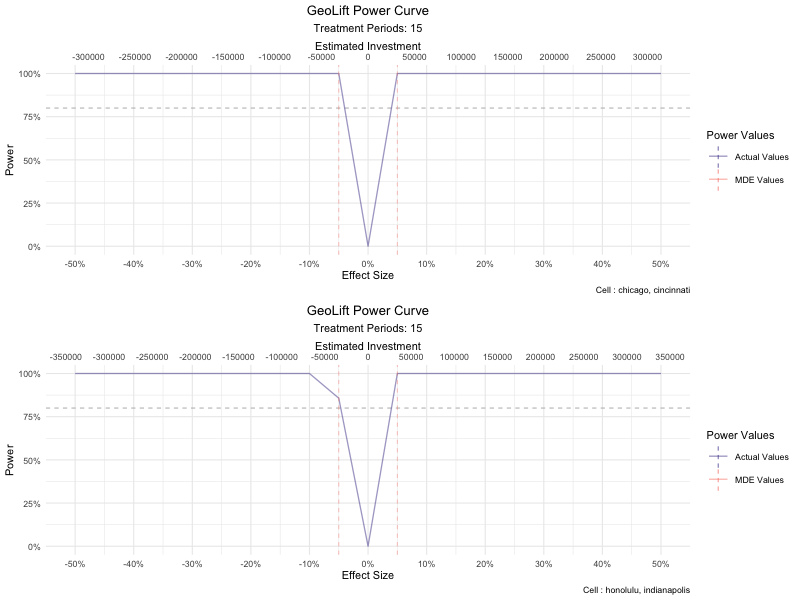

In [34]:
make_market_deep_dive_plot_multicell(r, market_ids=[1, 3], lookback_window=7, inline=True)

>left off here:\
https://facebookincubator.github.io/GeoLift/docs/GettingStarted/MultiCellWalkthrough/#optional-multicellwinner